In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import StratifiedShuffleSplit
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Malenov Dataset

Let's load the malenov dataset. This has been extracted from [MalenoV Github](https://github.com/bolgebrygg/MalenoV) using @JesperDramschs modified split code [here](https://github.com/JesperDramsch/MalenoV/tree/master/malenov).

The extracted data and seismic has also been stored in this [Google Drive](https://drive.google.com/open?id=1qeUTCsTBtjj7GbBXClwdguVwoLwcdO7h)  
Original Data is found [here](https://drive.google.com/drive/folders/0B7brcf-eGK8CRUhfRW9rSG91bW8) provided via PeterBormann (ConoccoPhilips)

In [65]:
data_dir = "../../data/malenov/"
labels = np.load(data_dir+"labels.npy")
indices = np.load(data_dir+"indices.npy")
print("Total Number of labeled points", labels.shape[0])

index_mins = indices.min(0)
index_maxs = indices.max(0)

Total Number of labeled points 158557


We'll set the cube half size to that of the original MalenoV implementation.

In [66]:
cube_half_size = 32

## Extracting the valid data points given the cube half size

We'll have to make sure all our data points are within the bounds of the seismic given the size of the patches being (32*32+1)^3.  

In [67]:
valid_indices = []
valid_labels = []
for index, label in zip(indices, labels):
    if [(index_mins[i]+cube_half_size <= index[i] < index_maxs[i]-cube_half_size) for i in range(1,3)] == [True]*2:
        valid_indices.append(index)
        valid_labels.append(label)
valid_indices = np.array(valid_indices)
valid_labels = np.array(valid_labels)

## Plotting the data within the bounds

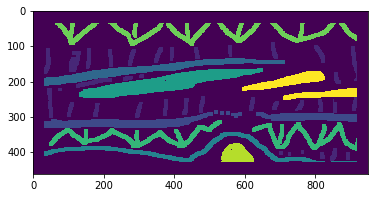

In [68]:
img = np.zeros((949, 462), dtype=np.int8)
for i in range(len(valid_indices)):
    img[valid_indices[i][1], valid_indices[i][2]] = valid_labels[i]+1
    
plt.imshow(img.T)

## Class label distribution for the valid labels within bounds

Number of labels per class:  [19407 17012 13041 10858 17991 18160 16064  7518 18854]


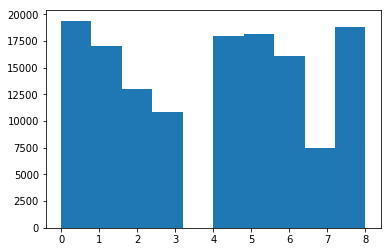

In [69]:
plt.hist(valid_labels)
print("Number of labels per class: ", np.unique(valid_labels, return_counts=True)[1])

## Possible Data Leak with overlapping patches

Just training on patches of data is going to create a data leak from train to validation/test.
Let's also split the dataset into two.  
The indices below are x-coordinates to split regions per class into roughly two regions: train and validation.

In [72]:
x_split_indices = [500, 500, 300, 500, 500, 500, 500, 575, 750] #class 0, class 1 etc

In [73]:
valid_train_indices = []
valid_val_indices = []
valid_train_labels = []
valid_val_labels = []

for i in range(len(valid_indices)):
    if valid_indices[i][1] <= x_split_indices[valid_labels[i]]-cube_half_size:
        valid_train_indices.append(valid_indices[i])
        valid_train_labels.append(valid_labels[i])
    elif valid_indices[i][1] > x_split_indices[valid_labels[i]]+cube_half_size:
        valid_val_indices.append(valid_indices[i])
        valid_val_labels.append(valid_labels[i])  

## Plotting the training labels split left right

Text(0.5,1,'Validation Labels')

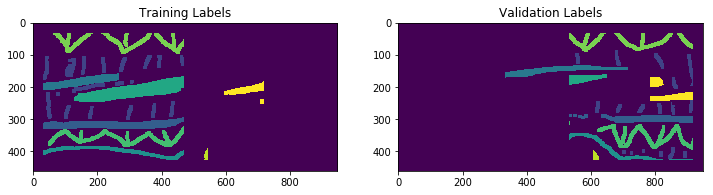

In [75]:
img_train = np.zeros((949, 462), dtype=np.int8)
for i in range(len(valid_train_indices)):
    img_train[valid_train_indices[i][1], valid_train_indices[i][2]] = valid_train_labels[i]+2

img_val = np.zeros((949, 462), dtype=np.int8)
for i in range(len(valid_val_indices)):
    img_val[valid_val_indices[i][1], valid_val_indices[i][2]] = valid_val_labels[i]+2

    
fig, ax = plt.subplots(1, 2, figsize=(12, 24))
ax[0].imshow(img_train.T)
ax[1].imshow(img_val.T)
ax[0].set_title("Training Labels")
ax[1].set_title("Validation Labels")

## Train/Val Class Label Distributions

A bit unbalanced on class 4 but close enough for now.

(array([7066., 6371., 6037., 4069.,    0., 2489., 8233., 6969.,  752.,
        7656.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

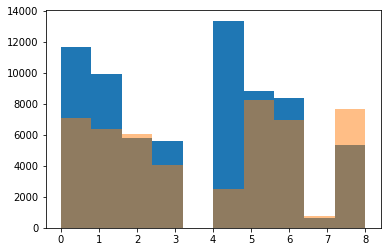

In [76]:
plt.hist(valid_train_labels)
plt.hist(valid_val_labels, alpha=0.5)

## Saving left/right split indices for training purposes

To run Pytorch-MalenoV with this dataset split, run it without the ```--use_stratified_kfold``` flag.

In [62]:
split_train = np.array([valid_train_indices, valid_train_labels])
split_val = np.array([valid_val_indices, valid_val_labels])
np.save("../split/train_split.npy", split_train)
np.save("../split/val_split.npy", split_val)